(time-frequency-analysis)=
# Time-Frequency Analysis

In this section we will discuss the representation of signals in time and frequency domain and how it can be useful for analysis.

## Fourier Series Expansion

Let's revisit the sine wave example. It can be represented by its amplitude, frequency, and phase. 


A periodic signal can be decomposed into a sum of sine waves with different amplitudes, frequencies, and phases. For example, below is a decomposition of a square wave.

$$\textrm{square wave} = sin(x) + sin(3x)/3 + sin(5x)/5 + sin(7x)/7 ...$$

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Sigma-approximation_of_a_Square_Wave_.gif)



Image Source: Wikipedia

The representation can be obtained by calculating the [**Fourier Series**](https://mathworld.wolfram.com/FourierSeries.html) for the function. 

## Fourier Transform

The analogue for this representation for discrete signals can be obtained through the **Discrete Fourier Transform** (DFT), converts the signal from the **time domain** to **frequency domain**. We can interpret the operation as decomposing the signal into many different frequencies.

In practice, we usually use the Fast Fourier Transform (FFT) algorithm to compute the DFT, as we will do in the examples below.


<!-- $$ \mathcal{\hat{f}}[k] = \sum_{n=0}^{N-1}e^{-2\pi j \frac{kn}{N}}f[n] $$

This converts the signal from the time domain to frequency domain. -->


<!-- :::{note}
We can interpret it as a matched filter against waves with different frequencies.
::: -->

### Sine wave

In [1]:
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [2]:
# Time base used for all signals in this notebook
N = 1000
end_time = 1
time = np.linspace(0, end_time, end_time*N, endpoint=False) # 1 sec

In [3]:
# Sine Wave
freq = 50
A = 1
cw = A*np.sin(2*np.pi*freq*time)

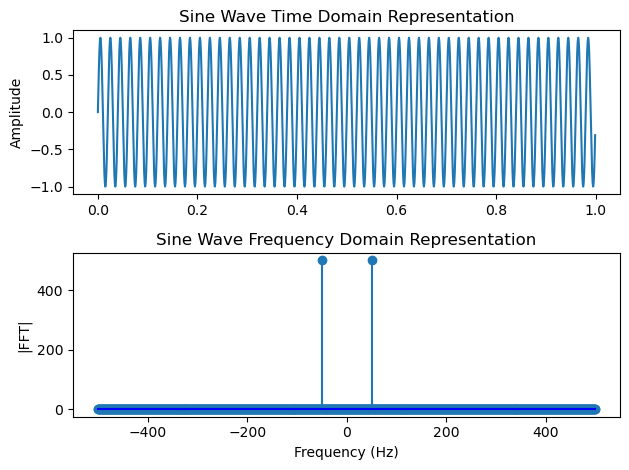

In [4]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, cw)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.stem(fftfreq(N, 1)*N, np.abs(fft(cw)), basefmt='b-')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
The FFT is symmetric and the maximum positive frequency is half the sampling frequency (within which we can accurately reconstruct the signal thanks to the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)). We can limit to display only one side of the plot.
:::

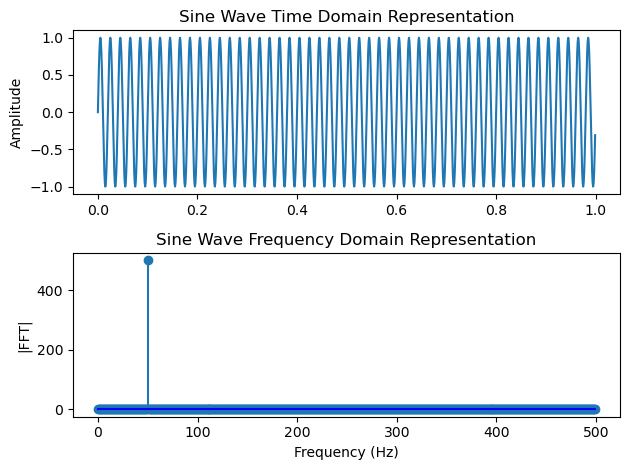

In [5]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, cw)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.stem(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(cw))[:(N//2)], basefmt='b-')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
We can see that the only npn-zero frequency is 100Hz, the frequency of the sine wave.
:::

### Chirp

In [6]:
# Chirp
chirp = sp.signal.chirp(time, f0=1, t1=1, f1=100)

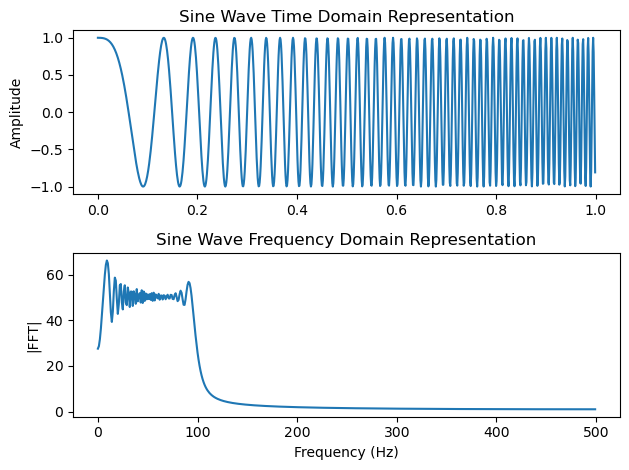

In [7]:
# Chirp FFT

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, chirp)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

# ax2.stem(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(chirp))[:(N//2)], basefmt='b-')
ax2.plot(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(chirp))[:(N//2)])#, '.', markerfacecolor='none')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
We can see that the chirp contains frequency information across a range of frequencies (1-100 Hz).
:::

## Short-Time Fourier Transform and Spectrogram

The frequency content of a chirp changes over time. This is hard to see in the pure frequency domain representation shown in the above. To capture the temporally varying frequency content of a signal, we can split the signal into short segments, compute the FFT for each segment, and plot the magnitude spectum against both time and frequency. This operation is referred to as **Short-Term Fourier Transform** and the result can be visualized as the **spectrogram**. Note that these segments can be overlapping, which can help capture the transient nature of the signal.

### Sine wave

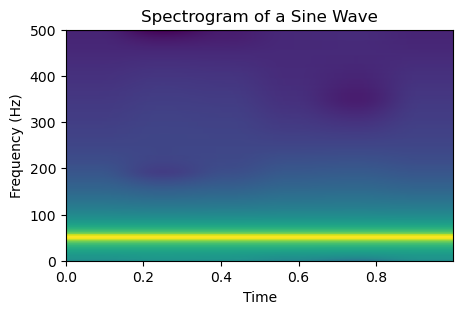

In [8]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(cw, NFFT = 256, Fs = N, xextent=[time[0],time[-1]])
plt.title("Spectrogram of a Sine Wave")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

:::{note}
Since the frequency is constant we observe a horizontal bar at 100Hz.
:::

### Chirp

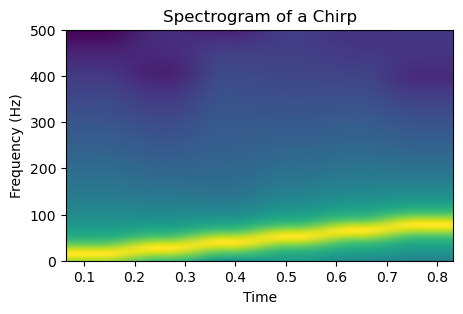

In [9]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs=N)
plt.title("Spectrogram of a Chirp")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

:::{note}
We observe the linear increase of frequency over time. The line looks smooth but slightly wiggly. This is a result of the automatic interpolation of the plotting function, which can be turned off to correctly interpret the discrete values.
:::

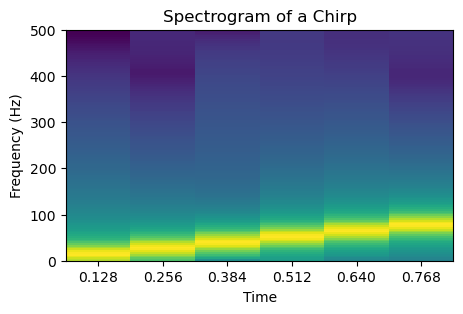

In [10]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs=N, interpolation='none', mode='magnitude')
plt.title("Spectrogram of a Chirp")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
out = plt.xticks(s_t)

The `plt.specgram` function has a lot of parameters which are hidden under the hood in the above default call. We will explain how they affect the creation of the spectrogram. The key parameters that affect the shape (and the resolution) of the output image are the intervals into which we split the original signal and whether those intervals are overlapping. This determines the number of time and frequency bins of the spectrograms.

![](https://www.mathworks.com/help/signal/ug/siganalyzer_display.png)

It is crucial to read the documentation of the actual spectrogram function since the vocabulary can vary across libraries.

For example, by check the [`specgram` function documentation page](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html), we can see that:
* `NFFT` is the number of points in each segment. By default it is set to 256.
* `noverlap` is the number of points of overlap. By default it is set to 128.

We will use these in the examples below.

<!-- help(plt.specgram) -->

:::{note}
In the above plot, the xticks are located at the center of the segment from which the FFT is computed. The spacing between two consecutive xticks is 128/1000 which corresponds to (`NFFT` - `noverlap`)/`N`.
:::

### Spectrogram Widget

We will demonstrate how the spectrogram is created through a widget.

In [11]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [12]:
def plot_stft_slice(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2,2)
    fig.set_figheight(6)
    fig.set_figwidth(10)


    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(time, chirp)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(chirp, NFFT=NFFT, noverlap=noverlap, Fs = N, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    ax[0,0].set_ylim((-1.1,1.1))
    ax[0,0].set_xlim((0,1))
    ax[0,0].set_title("Chirp")


    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_title("STFT")
    ax[1,0].set_xticks(np.concat(([0],s_t, [1])))
    print(s_t)


    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx], s_freq)
    ax[1,1].set_xlabel("|FFT|")
    ax[1,1].set_title("|FFT|")
    ax[1,1].set_xlim((-0.001, 0.1))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [13]:
NFFT_widget = widgets.SelectionSlider(value=256, options=[256, 512, 1024])
noverlap_widget = widgets.SelectionSlider(value=128, options=[0,32,64,128])

time_widget = widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N)

# Update function
def update_time_slider(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N

NFFT_widget.observe(update_time_slider, names='value')
noverlap_widget.observe(update_time_slider, names='value')

out = interactive(plot_stft_slice, NFFT=NFFT_widget, noverlap=noverlap_widget, t=time_widget)
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.128), np.float64(0.256), np.float…

### Impulse

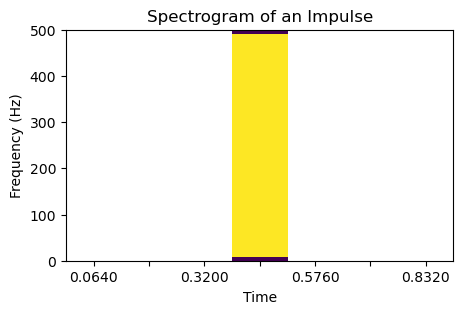

In [14]:
import warnings

impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
plt.figure(figsize=(5,3))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # hide divided by zero warning
    s, s_freq, s_t, im = plt.specgram(
        impulse, NFFT=128, noverlap=0, Fs=N, interpolation='none'
    )
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

# Only print out every third of the x ticks to avoid overlapping
locs, labels = plt.xticks()
new_labels = [f"{loc:.4f}" if i % 2 == 0 else "" for i, loc in enumerate(locs)]
plt.xticks(locs, new_labels)

plt.show()

:::{caution}
What is going on? By default `plt.specgram` plots on the log scale (in dB). When the value is zero the resulting plot contains NaNs, which are the empty space in the above plot.

To avoid this problem, we can plot on the linear scale by setting `scale='linear'`. We should also check the type of spectrum used. By default the function uses `mode="psd"`, a statistical estimate of the spectrum. We can plot the magnitude of the FFT by using `mode='magnitude"`.
:::

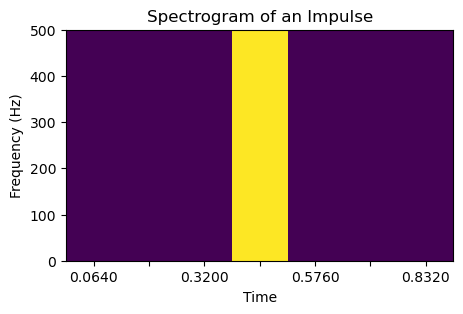

In [15]:
impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(
    impulse, NFFT=128, noverlap=0, Fs=N, interpolation='none',
    scale='linear', mode='magnitude'
) 
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

# Only print out every third of the x ticks to avoid overlapping
locs, labels = plt.xticks()
new_labels = [f"{loc:.4f}" if i % 2 == 0 else "" for i, loc in enumerate(locs)]
plt.xticks(locs, new_labels)

plt.show()

We see that the spectrogram is positive only at the timestamp of the impulse and exhibits all frequencies.

### An call from an orca

Now that we have a better understanding of the spectrogram, let's look at one real example: a call of an orca from the [Watkins Marine Mammal Sound Database](https://whoicf2.whoi.edu/science/B/whalesounds/).

In [16]:
# Listening to the call
import IPython
IPython.display.Audio("https://whoicf2.whoi.edu/science/B/whalesounds/WhaleSounds/92301007.wav")

In [17]:
# reading a buzz call
from scipy.io import wavfile
samplerate, signal = wavfile.read("../resources/watkins_orca_92301007.wav")

In [18]:
N = len(signal)

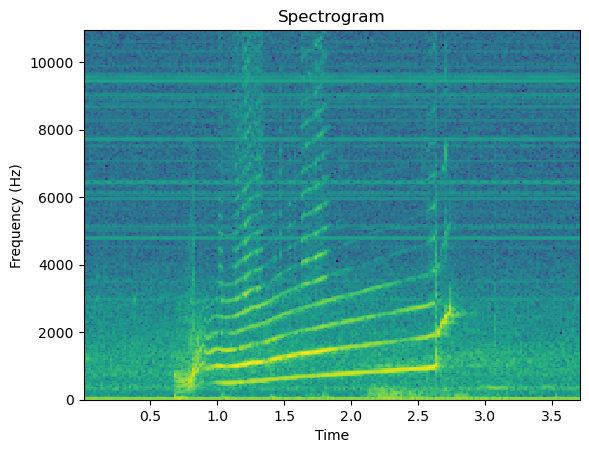

In [19]:
s, s_freq, s_t, im = plt.specgram(signal, NFFT=512, Fs=samplerate, interpolation='none')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

In [20]:
def plot_stft_slice(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2,2)
    fig.set_figheight(6)
    fig.set_figwidth(10)


    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(np.linspace(0,len(signal)/samplerate, len(signal)), signal)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(signal, NFFT=NFFT, noverlap=noverlap, Fs = samplerate, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    #ax[0,0].set_ylim((-2,2))
    ax[0,0].set_xlim((0, N/samplerate))
    ax[0,0].set_title("Signal")


    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_title("STFT")
    ax[1,0].set_xlim((0, N/samplerate))
    # ax[1,0].set_xticks(np.concat(([0], s_t, [N/samplerate])))

    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx]/s.max(), s_freq)
    ax[1,1].set_xlabel("normalized |FFT|")
    ax[1,1].set_title("|FFT|")
    ax[1,1].set_xlim((-0.001, 1))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [21]:
NFFT_widget = widgets.SelectionSlider(options=[256, 512, 1024, 2048])
NFFT_widget.value = 256
noverlap_widget = widgets.SelectionSlider(options=[0,32,64,128])
noverlap_widget.value = 128

time_widget = widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/samplerate)


# Update function
def update_time_slider(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/samplerate

NFFT_widget.observe(update_time_slider, names='value')
noverlap_widget.observe(update_time_slider, names='value')


out = interactive(plot_stft_slice, NFFT=NFFT_widget, noverlap=noverlap_widget, t=time_widget)
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.005844748858447488), np.float64(0…

Explore how the spectrum changes with time and how the NFFT affects the resolution.